In [256]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from itertools import combinations
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import entropy



In [257]:
# import Data
iris = datasets.load_iris()
wine = datasets.load_wine()
breast_cancer = datasets.load_breast_cancer()
houses = datasets.load_boston()

In [258]:
# Functions - https://github.com/fboldt/aulasml/blob/master/arvore.ipynb

def plotdecisao(modelo, X, y, data, title):
    modelo.fit(X, y)
    X0s = np.linspace(np.min(X[:, 0])-0.2, np.max(X[:, 0])+0.2, 100)
    X1s = np.linspace(np.min(X[:, 1])-0.2, np.max(X[:, 1])+0.2, 100)
    x0, x1 = np.meshgrid(X0s, X1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], 
                 X[:,1][y==k], 
                 'o') 
                 #label=f'{data.target_names[k]} - [{k}]')
    plt.xlabel(f'X[0]: {data.feature_names[pair[0]]}')
    plt.ylabel(f'X[1]: {data.feature_names[pair[1]]}')
    plt.title(title)
    plt.show()


def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


def impurezaMinima(x, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor(x[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza



def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica],\
            impurezas[caracteristica]


from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y
    




In [259]:
def impureza_entropy(y): #Entropy
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = entropy(probabilidades)
    return result

def impurezaValor_nh(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza_entropy(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza_entropy(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

def impurezaMinima_nh(x, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezasValorCaracteristica = impurezaValor_nh(x[:,i], y, valor)
            impurezas.append(impurezasValorCaracteristica)
    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorimpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorimpureza]
    return impurezas[menorimpureza], int(caracteristica), valor



def melhorValor_randon(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        #Crie a sua heurística para escolher a melhor característica para 
        # um nó de uma árvore de decisão
        valor = np.random.uniform(xmax, xmin, 1)[0]
        impTotal, impMaiores, impMenores = impurezaValor_nh(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

def melhorCaracteristica_randon(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor_randon(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica],\
            impurezas[caracteristica]

class Arvore_Nova_Heuri(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = \
        melhorCaracteristica_randon(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y
    




In [260]:
# Exemplo Nova Heuritsica escolhida com aleatoriedade no valor limiar
X, y = iris.data[:,2:], iris.target
modelo = Arvore()
modelo.fit(X, y)
#ypred_mod = modelo.predict(X)
#print(accuracy_score(y, ypred_mod), (ypred_mod == y))
modelo_nova_heuritica = Arvore_Nova_Heuri()
modelo_nova_heuritica.fit(X,y)
#ypred_nh = modelo_nova_heuritica.predict(X)
#accuracy_score(y, ypred_nh), (ypred_nh == y)

------------------------------------------------------------


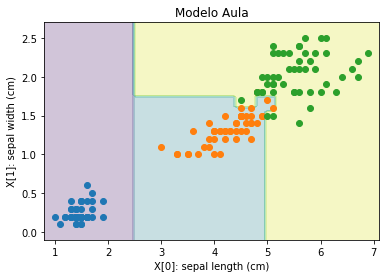

------------------------------------------------------------


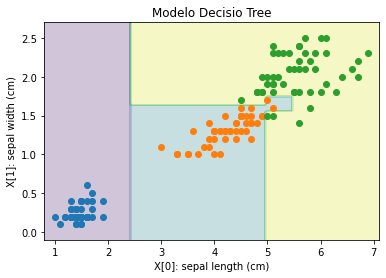

------------------------------------------------------------


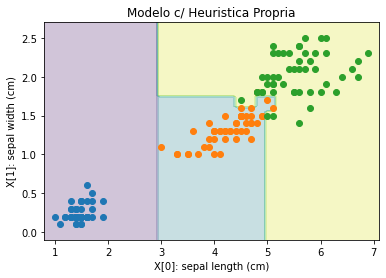

------------------------------------------------------------


In [261]:
# Faça comparações plotando as regiões de decisão com resubstituição 
# para a base iris e as características usadas nos vídeos.
print('-'*60)
# Exemplo SkLearn Modelo apresentado nos videos
plotdecisao(modelo, X, y, iris, 'Modelo Aula')
print('-'*60)
# Exemplo SkLearn Padrao
plotdecisao(DecisionTreeClassifier(), X, y, iris, 'Modelo Decisio Tree')
print('-'*60)
# Exemplo SkLearn Padrao
plotdecisao(modelo_nova_heuritica, X, y, iris, 'Modelo c/ Heuristica Propria')
print('-'*60)

In [262]:
'''
Também faça comparações usando validação cruzada com pelo menos 3 bases 
de classificação com atributos contínuos
'''
from sklearn.model_selection import cross_validate

# Trasformando target de regressao em classificacao
houses.target = np.where(houses.target > houses.target.mean(), 1, 0)

bases = [iris, wine, breast_cancer, houses]
base_names = ['Iris','Wine','Breast Cancer','Boston Houses']
for base, base_name in zip(bases, base_names):
    X, y = base.data, base.target
    print('='*40)
    print(f"Validacao Cruzada p/ Base - {base_name}")
    print('.'*40)
    cval_aula = cross_validate(Arvore(), X, y)
    print(f"CV Aula:{cval_aula['test_score']}") 
    print(f"Score médio Aula: {cval_aula['test_score'].mean():.2f}")
    cval_pad = cross_validate(DecisionTreeClassifier(), X, y)
    print('_'*40)
    print(f"CV Decision Tree:{cval_pad['test_score']}") 
    print(f"Score médio DT: {cval_pad['test_score'].mean():.2f}")
    print('_'*40)
    cval_prop = cross_validate(modelo_nova_heuritica, X, y)
    print(f"CV Nova Heurístiva:{cval_prop['test_score']}") 
    print(f"Score médio Nova Heurística: {cval_prop['test_score'].mean():.2f}")
    print('='*40)




    


Validacao Cruzada p/ Base - Iris
........................................
CV Aula:[0.96666667 0.96666667 0.9        0.93333333 1.        ]
Score médio Aula: 0.95
________________________________________
CV Decision Tree:[0.96666667 0.96666667 0.9        1.         1.        ]
Score médio DT: 0.97
________________________________________
CV Nova Heurístiva:[0.96666667 0.96666667 0.86666667 0.93333333 0.96666667]
Score médio Nova Heurística: 0.94
Validacao Cruzada p/ Base - Wine
........................................
CV Aula:[0.77777778 0.88888889 0.83333333 1.         0.97142857]
Score médio Aula: 0.89
________________________________________
CV Decision Tree:[0.91666667 0.77777778 0.88888889 0.91428571 0.85714286]
Score médio DT: 0.87
________________________________________
CV Nova Heurístiva:[0.77777778 0.80555556 0.91666667 1.         0.91428571]
Score médio Nova Heurística: 0.88
Validacao Cruzada p/ Base - Breast Cancer
........................................
CV Aula:[0.92982456

## Escreva um parágrafo expondo sua interpretação dos resultados obtidos.

Como nova heurística, foram exploradas 2 variáveis: impureza e a forma de chegar no valor inicial na função "melhor valor". No lugar de impureza de Gini foi utilizado entropia de ganho de informações e para o melhor valor, exploramos um valor aleatório entre os limites ao invés da média dos limites. Apesar de um overfit na base Iris, não foi possível identificar redução significativa na performance com a nova heurística na validação cruzada para outras bases, com os resultados bem próximos aos outros modelos, mesmo com um tempo de execução ligeiramente maior.